https://www.kaggle.com/datasets/xhlulu/140k-real-and-fake-faces?select=test.csv


In [9]:
import os
import cv2
from collections import Counter
import pandas as pd
import numpy as np
from PIL import Image, ImageOps
from matplotlib import pyplot as plt
from torchvision import transforms
import torch
import random
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split,Subset
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import CosineAnnealingLR
import torch.nn.functional as F
import kagglehub
from glob import glob
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.utils import PyDataset
from tensorflow.keras import layers, models

# Download latest version
path = kagglehub.dataset_download("xhlulu/140k-real-and-fake-faces")

print("Path to dataset files:", path)


Path to dataset files: C:\Users\lzx13\.cache\kagglehub\datasets\xhlulu\140k-real-and-fake-faces\versions\2


In [10]:
# ======================================
# Data Configuration
# ======================================
IMG_SIZE = (224, 224)  # Can adjust to 256x256 if needed
BATCH_SIZE = 32
INPUT_SHAPE = (*IMG_SIZE, 3)

# ======================================
# Create Data Generators
# ======================================
# Define paths (MODIFY THESE PATHS IF NEEDED)
TRAIN_DIR = 'C:/Users/lzx13/.cache/kagglehub/datasets/xhlulu/140k-real-and-fake-faces/versions/2/real_vs_fake/real-vs-fake/train'
VAL_DIR = 'C:/Users/lzx13/.cache/kagglehub/datasets/xhlulu/140k-real-and-fake-faces/versions/2/real_vs_fake/real-vs-fake/valid'
TEST_DIR = 'C:/Users/lzx13/.cache/kagglehub/datasets/xhlulu/140k-real-and-fake-faces/versions/2/real_vs_fake/real-vs-fake/test'

# Create base generators with normalization
train_datagen = ImageDataGenerator(rescale=1./255)
valid_test_datagen = ImageDataGenerator(rescale=1./255)

# Load datasets
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=True  # Explicitly shuffle training data
)

valid_generator = valid_test_datagen.flow_from_directory(
    VAL_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False  # No shuffle for validation
)

test_generator = valid_test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False  # No shuffle for test
)

# Verify class indices
print("\nClass indices:", train_generator.class_indices)


Found 100000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.

Class indices: {'fake': 0, 'real': 1}


In [9]:
# ======================================
# Setup for GPU acceleration using your NVIDIA 4090 GPU
# ======================================
# This code enables CUDA acceleration on available GPUs.
# It sets memory growth to avoid allocating all GPU memory at once.

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("GPUs are set for CUDA acceleration using your NVIDIA 4090 GPU.")
    except RuntimeError as e:
        print(e)

# ======================================
# Define the input shape for the models
# ======================================
# You can adjust INPUT_SHAPE based on your dataset dimensions.
INPUT_SHAPE = (224, 224, 3)

# ======================================
# Example Model 1: Original CNN
# ======================================
def build_cnn_model():
    # Hyperparameters you can adjust:
    # - Number of filters in Conv2D layers (e.g., 32, 64, 128)
    # - Kernel size for convolution layers (e.g., (3,3))
    # - Pooling size in MaxPooling2D layers (e.g., (2,2))
    # - Dropout rate (e.g., 0.5)
    # - Number of units in Dense layers (e.g., 512)
    # - Learning rate for the optimizer (e.g., 0.0001)

    model = Sequential([
        # First convolutional block
        Conv2D(32, (3, 3), activation='relu', input_shape=INPUT_SHAPE),  # 32 filters, 3x3 kernel
        MaxPooling2D(2, 2),  # Pool size 2x2

        # Second convolutional block
        Conv2D(64, (3, 3), activation='relu'),  # 64 filters, 3x3 kernel
        MaxPooling2D(2, 2),

        # Third convolutional block
        Conv2D(128, (3, 3), activation='relu'),  # 128 filters, 3x3 kernel
        MaxPooling2D(2, 2),

        Flatten(),  # Flatten the output to feed into dense layers
        Dropout(0.5),  # Dropout layer with rate 0.5 (adjustable to control overfitting)
        Dense(512, activation='relu'),  # Dense layer with 512 units
        Dense(1, activation='sigmoid')  # Output layer for binary classification
    ])

    # Optimizer with adjustable learning rate
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)  # Adjust learning rate if necessary

    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',  # Loss function for binary classification
        metrics=['accuracy']  # Metric to monitor performance
    )
    return model

# ======================================
# Model 2: Pretrained ResNet50
# ======================================
def build_resnet_model():
    # Hyperparameters you can adjust:
    # - Choice of pretrained model and its configuration (e.g., ResNet50 with imagenet weights)
    # - Whether to freeze the base model layers or fine-tune them (base_model.trainable)
    # - Number of units in the dense layer after the base model (e.g., 256)
    # - Dropout rate (e.g., 0.5)

    # Load the pretrained ResNet50 model without the top layers
    base_model = ResNet50(
        weights='imagenet',
        include_top=False,
        input_shape=INPUT_SHAPE
    )

    # Freeze the base model layers to retain pretrained features.
    # Change to "base_model.trainable = True" if you plan to fine-tune.
    base_model.trainable = False

    model = Sequential([
        base_model,
        Flatten(),  # Flatten the output from the base model
        Dense(256, activation='relu'),  # Dense layer with 256 units (adjustable)
        Dropout(0.5),  # Dropout layer to reduce overfitting
        Dense(1, activation='sigmoid')  # Output layer for binary classification
    ])

    # Optimizer can be adjusted (e.g., setting a different learning rate)
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

#========================
#mobilenetv2
#========================
def build_mobilenetv2_model():
    """
    Builds and returns a MobileNetV2-based model for binary classification.
    This function replaces the ResNet50 model with minimal code changes.
    Other parts of the training code remain the same.
    """
    # Load the pretrained MobileNetV2 model with ImageNet weights
    # 'include_top=False' removes the original classification head
    # 'input_shape=INPUT_SHAPE' ensures it matches your data dimensions
    base_model = tf.keras.applications.MobileNetV2(
        weights='imagenet', 
        include_top=False, 
        input_shape=INPUT_SHAPE
    )

    # Freeze all layers in the base model to retain the pretrained features
    base_model.trainable = False

    # Build a new classification head on top of MobileNetV2
    model = Sequential([
        base_model,
        Flatten(),              # Flatten the feature maps
        Dense(256, activation='relu'),  # Dense layer with 256 units
        Dropout(0.5),          # Dropout for regularization
        Dense(1, activation='sigmoid')  # Output layer for binary classification
    ])

    # Compile the model using the same hyperparameters as your ResNet code
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model


In [10]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import Callback

class MisclassifiedFakeLogger(Callback):
    def __init__(self, valid_generator, valid_dir, max_images=10):
        super().__init__()
        self.valid_generator = valid_generator
        self.valid_dir = valid_dir
        self.max_images = max_images

    def on_epoch_end(self, epoch, logs=None):
        self.valid_generator.reset()
        preds = self.model.predict(
            self.valid_generator, 
            steps=len(self.valid_generator), 
            verbose=0
        ).flatten()

        y_true = self.valid_generator.classes
        filenames = self.valid_generator.filenames

        # ✅ 真实标签是 fake (0)，但模型预测为 real (>= 0.5)
        misclassified_indices = np.where((y_true == 1) & (preds <= 0.5))[0]

        if len(misclassified_indices) == 0:
            print(f"[Epoch {epoch+1}] 没有错误识别的 fake 图片。")
            return

        np.random.shuffle(misclassified_indices)
        selected_indices = misclassified_indices[:self.max_images]

        print(f"[Epoch {epoch+1}] 展示 {len(selected_indices)} 张被误识别为 real 的 fake 图片：")

        for idx in selected_indices:
            file_path = os.path.join(self.valid_dir, filenames[idx])
            img = plt.imread(file_path)

            plt.imshow(img)
            plt.title(f"True: Fake(0), Pred: {preds[idx]:.4f} → Real(1)")
            plt.axis('off')
            plt.show()


misclassified_logger = MisclassifiedFakeLogger(
    valid_generator=valid_generator, 
    valid_dir=VAL_DIR, 
    max_images=10  # 每个 epoch 最多显示10张
)

In [11]:
import csv
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import Callback

# ======================================
# test record
# ======================================
class ExperimentLogger(Callback):
    def __init__(self, test_generator, csv_path='training_logs.csv'):
        super().__init__()
        self.test_generator = test_generator
        self.csv_path = csv_path
        self.results = []
        
        self.test_steps = test_generator.samples // test_generator.batch_size

    def on_train_begin(self, logs=None):
        # initialize 
        with open(self.csv_path, 'w', newline='') as file:
            writer = csv.writer(file)
            writer.writerow([
                'epoch', 'train_loss', 'train_acc',
                'val_loss', 'val_acc', 'test_loss', 'test_acc'
            ])

    def on_epoch_end(self, epoch, logs=None):
        # reset test_geberator
        self.test_generator.reset()
        
        test_loss, test_acc = self.model.evaluate(
            self.test_generator,
            steps=self.test_steps,
            verbose=0
        )
        
        # collect data
        log_data = {
            'epoch': epoch + 1,
            'train_loss': logs.get('loss'),
            'train_acc': logs.get('accuracy'),
            'val_loss': logs.get('val_loss'),
            'val_acc': logs.get('val_accuracy'),
            'test_loss': test_loss,
            'test_acc': test_acc
        }
        self.results.append(log_data)
        
        # write in CSV（four digits）
        with open(self.csv_path, 'a', newline='') as file:
            writer = csv.writer(file)
            writer.writerow([
                log_data['epoch'],
                round(log_data['train_loss'], 4),
                round(log_data['train_acc'], 4),
                round(log_data['val_loss'], 4),
                round(log_data['val_acc'], 4),
                round(log_data['test_loss'], 4),
                round(log_data['test_acc'], 4)
            ])
# ======================================
# add logger for training
# ======================================
# initialize model
model = build_cnn_model()

early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

# create logger
experiment_logger = ExperimentLogger(test_generator, csv_path='resnet_experiment_logs.csv')

# train model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_data=valid_generator,
    validation_steps=valid_generator.samples // BATCH_SIZE,
    epochs=20,
    callbacks=[early_stop, experiment_logger]  # add logger
)

Epoch 1/20
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 742s 237ms/step - accuracy: 0.6839 - loss: 0.5824 - val_accuracy: 0.8259 - val_loss: 0.3942
Epoch 2/20
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 699s 224ms/step - accuracy: 0.8391 - loss: 0.3678 - val_accuracy: 0.8716 - val_loss: 0.3004
Epoch 3/20
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 701s 224ms/step - accuracy: 0.8870 - loss: 0.2742 - val_accuracy: 0.9121 - val_loss: 0.2187
Epoch 4/20
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 721s 231ms/step - accuracy: 0.9172 - loss: 0.2068 - val_accuracy: 0.9376 - val_loss: 0.1739
Epoch 5/20
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 718s 230ms/step - accuracy: 0.9366 - loss: 0.1617 - val_accuracy: 0.9491 - val_loss: 0.1361
Epoch 6/20
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 848s 271ms/step - accuracy: 0.9533 - loss: 0.1238 - val_accuracy: 0.9582 - val_loss: 0.1151
Epoch 7/20
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 1226s 392ms/step - accuracy: 0.9652 - loss: 0.0943 - val_accuracy: 0.9646 - val_loss: 0.0983
Epoch 8/20
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 893s 286ms/step - a

In [13]:
# 定义保存路径和文件名 (添加 .keras 扩展名)
saved_model_path = './my_model_trained_on_A.keras' 

# 保存模型
print(f"正在将模型保存到 {saved_model_path}...")
model.save(saved_model_path)
print("模型已保存。")

# 加载时也使用相同的路径
loaded_model = tf.keras.models.load_model(saved_model_path)

正在将模型保存到 ./my_model_trained_on_A.keras...
模型已保存。


In [14]:
# 定义保存路径和文件名 (添加 .h5 扩展名)
saved_model_path = './my_model_trained_on_A.h5'

# 保存模型
print(f"正在将模型保存到 {saved_model_path}...")
model.save(saved_model_path)
print("模型已保存。")

# 加载时也使用相同的路径
# loaded_model = tf.keras.models.load_model(saved_model_path)

正在将模型保存到 ./my_model_trained_on_A.h5...
模型已保存。


In [15]:
# 定义要保存到的目录路径 (不需要扩展名)
saved_model_directory = './my_model_trained_on_A_savedmodel' 

# 导出模型为 SavedModel 格式
print(f"正在将模型导出到 SavedModel 目录 {saved_model_directory}...")
model.export(saved_model_directory)
print("模型已导出。")

# 加载时使用目录路径
# loaded_model = tf.keras.models.load_model(saved_model_directory)

正在将模型导出到 SavedModel 目录 ./my_model_trained_on_A_savedmodel...
INFO:tensorflow:Assets written to: ./my_model_trained_on_A_savedmodel\assets


INFO:tensorflow:Assets written to: ./my_model_trained_on_A_savedmodel\assets


Saved artifact at './my_model_trained_on_A_savedmodel'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_11')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  2016903195408: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2016903197136: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2016903196560: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2016903197904: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2016903197328: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2016903198672: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2016903198096: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2016903199440: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2016903198864: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2016903200208: TensorSpec(shape=(), dtype=tf.resource, name=None)
模型已导出。


In [1]:
# ======================================
# Visualization Function
# ======================================
def plot_training_curves(csv_path, figsize=(12, 6)):
    # Read CSV data
    import pandas as pd
    df = pd.read_csv(csv_path)

    # Create plots
    plt.figure(figsize=figsize)

    # Loss curves
    plt.subplot(1, 2, 1)
    plt.plot(df['epoch'], df['train_loss'], label='Train Loss')
    plt.plot(df['epoch'], df['val_loss'], label='Val Loss')
    plt.plot(df['epoch'], df['test_loss'], label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Curves')
    plt.legend()

    # Accuracy curves
    plt.subplot(1, 2, 2)
    plt.plot(df['epoch'], df['train_acc'], label='Train Acc')
    plt.plot(df['epoch'], df['val_acc'], label='Val Acc')
    plt.plot(df['epoch'], df['test_acc'], label='Test Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Curves')
    plt.legend()

    plt.tight_layout()
    plt.savefig('standard_30epoch_experiment_logs.png') 
    plt.show()

# 生成图表
plot_training_curves('standard_30epoch_experiment_logs.csv')

FileNotFoundError: [Errno 2] No such file or directory: 'standard_30epoch_experiment_logs.csv'

Loading model from ./my_model_trained_on_A.keras...
Model loaded successfully.
Downloading/Locating 'hardfakevsrealfaces' dataset...
Dataset path: C:\Users\lzx13\.cache\kagglehub\datasets\hamzaboulahia\hardfakevsrealfaces\versions\1
Loading new dataset from C:\Users\lzx13\.cache\kagglehub\datasets\hamzaboulahia\hardfakevsrealfaces\versions\1...
Found 1289 images belonging to 2 classes.
New dataset loaded successfully.
Class indices: {'fake': 0, 'real': 1}
Evaluating model on the new dataset...


c:\Users\lzx13\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.4288 - loss: 2.7033

Evaluation on the new dataset:
loss: 1.6982
compile_metrics: 0.6330

Making predictions on the new dataset (this may take a while)...
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step
Predictions and true classes obtained.

Accuracy Score: 0.6330488750969744

Classification Report:
              precision    recall  f1-score   support

        fake       1.00      0.33      0.49       700
        real       0.55      1.00      0.71       589

    accuracy                           0.63      1289
   macro avg       0.78      0.66      0.60      1289
weighted avg       0.79      0.63      0.59      1289


Confusion Matrix:
[[228 472]
 [  1 588]]


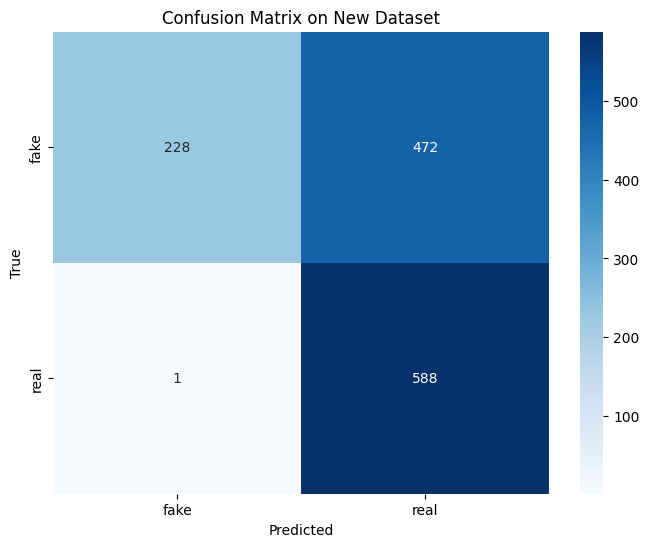


Testing script finished.


In [11]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
import os
import kagglehub # Make sure kagglehub is imported

# Define the path to your saved model
saved_model_path = './my_model_trained_on_A.keras'

# Load the saved model
print(f"Loading model from {saved_model_path}...")
try:
    loaded_model = tf.keras.models.load_model(saved_model_path)
    print("Model loaded successfully.")
except Exception as e:
    print(f"Error loading model: {e}")
    # Exit if the model cannot be loaded
    exit()

# --- START CORRECTION ---
# Define and download the path to the new dataset
print("Downloading/Locating 'hardfakevsrealfaces' dataset...")
try:
    # This line will define the 'path' variable
    path_to_new_dataset = kagglehub.dataset_download("hamzaboulahia/hardfakevsrealfaces")
    print(f"Dataset path: {path_to_new_dataset}")
except Exception as e:
    print(f"Error downloading dataset with kagglehub: {e}")
    exit()

NEW_DATASET_PATH = path_to_new_dataset # Use the newly defined path
# --- END CORRECTION ---

# Verify that the dataset path exists
if not os.path.exists(NEW_DATASET_PATH):
    print(f"Error: The dataset path {NEW_DATASET_PATH} does not exist or was not correctly returned by kagglehub.")
    exit()

# Image dimensions and batch size (should ideally match what the model was trained on)
IMG_SIZE = (loaded_model.input_shape[1], loaded_model.input_shape[2]) # Get input size from the loaded model
BATCH_SIZE = 32 # You can adjust this

# Create an ImageDataGenerator for the new dataset
# We only need rescaling, similar to how validation/test data is usually processed.
new_datagen = ImageDataGenerator(rescale=1./255)

# Create a generator for the new dataset
print(f"Loading new dataset from {NEW_DATASET_PATH}...")
try:
    new_generator = new_datagen.flow_from_directory(
        NEW_DATASET_PATH,
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='binary', # Assuming 'fake' and 'real' correspond to 0 and 1
        shuffle=False # Important for evaluation to keep track of predictions
    )
    print("New dataset loaded successfully.")
    print("Class indices:", new_generator.class_indices)
except Exception as e:
    print(f"Error creating data generator for the new dataset: {e}")
    exit()

# ... (the rest of your evaluation code remains the same) ...

# Check if the generator found any images
if new_generator.samples == 0:
    print(f"No images found in {NEW_DATASET_PATH}. Please check the directory structure.")
    print("Expected subdirectories 'fake' and 'real' with images inside.")
    exit()

# Evaluate the model on the new dataset
print("Evaluating model on the new dataset...")
try:
    evaluation_results = loaded_model.evaluate(new_generator, verbose=1)
    print("\nEvaluation on the new dataset:")
    for metric_name, metric_value in zip(loaded_model.metrics_names, evaluation_results):
        print(f"{metric_name}: {metric_value:.4f}")
except Exception as e:
    print(f"Error during model evaluation: {e}")
    exit()

# Optional: Get predictions and true labels to calculate more metrics or show a confusion matrix
print("\nMaking predictions on the new dataset (this may take a while)...")
try:
    predictions = loaded_model.predict(new_generator, verbose=1)
    predicted_classes = (predictions > 0.5).astype(int).flatten()
    true_classes = new_generator.classes
    filenames = new_generator.filenames

    print("Predictions and true classes obtained.")

    from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

    print("\nAccuracy Score:", accuracy_score(true_classes, predicted_classes))
    print("\nClassification Report:")
    target_names = [k for k, v in sorted(new_generator.class_indices.items(), key=lambda item: item[1])]
    print(classification_report(true_classes, predicted_classes, target_names=target_names))

    print("\nConfusion Matrix:")
    cm = confusion_matrix(true_classes, predicted_classes)
    print(cm)

    import seaborn as sns # Ensure seaborn is imported if you use it
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix on New Dataset')
    plt.show()

except Exception as e:
    print(f"Error during prediction or detailed metrics calculation: {e}")

print("\nTesting script finished.")

Locating/Downloading Dataset B ('hardfakevsrealfaces')...
Dataset B path: C:\Users\lzx13\.cache\kagglehub\datasets\hamzaboulahia\hardfakevsrealfaces\versions\1
Preparing combined training data in ./combined_train_data...
Removing existing combined directory: ./combined_train_data
Copying Dataset A training images...
Copied 50000 images from C:/Users/lzx13/.cache/kagglehub/datasets/xhlulu/140k-real-and-fake-faces/versions/2/real_vs_fake/real-vs-fake/train\fake to ./combined_train_data\fake
Copied 50000 images from C:/Users/lzx13/.cache/kagglehub/datasets/xhlulu/140k-real-and-fake-faces/versions/2/real_vs_fake/real-vs-fake/train\real to ./combined_train_data\real
Copying Dataset B images...
Copied 700 images from C:\Users\lzx13\.cache\kagglehub\datasets\hamzaboulahia\hardfakevsrealfaces\versions\1\fake to ./combined_train_data\fake
Copied 589 images from C:\Users\lzx13\.cache\kagglehub\datasets\hamzaboulahia\hardfakevsrealfaces\versions\1\real to ./combined_train_data\real
Finished prepa

c:\Users\lzx13\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


3165/3165 ━━━━━━━━━━━━━━━━━━━━ 53s 17ms/step - accuracy: 1.0000 - loss: 0.0043 - val_accuracy: 0.9787 - val_loss: 0.0618
Epoch 3/10
3165/3165 ━━━━━━━━━━━━━━━━━━━━ 740s 234ms/step - accuracy: 0.9947 - loss: 0.0197 - val_accuracy: 0.9790 - val_loss: 0.0609
Epoch 4/10
3165/3165 ━━━━━━━━━━━━━━━━━━━━ 24s 7ms/step - accuracy: 1.0000 - loss: 0.0021 - val_accuracy: 0.9790 - val_loss: 0.0610
Epoch 5/10
3165/3165 ━━━━━━━━━━━━━━━━━━━━ 692s 219ms/step - accuracy: 0.9954 - loss: 0.0162 - val_accuracy: 0.9803 - val_loss: 0.0598
Epoch 6/10
3165/3165 ━━━━━━━━━━━━━━━━━━━━ 24s 7ms/step - accuracy: 1.0000 - loss: 0.0012 - val_accuracy: 0.9804 - val_loss: 0.0599
Epoch 7/10
3165/3165 ━━━━━━━━━━━━━━━━━━━━ 690s 218ms/step - accuracy: 0.9960 - loss: 0.0141 - val_accuracy: 0.9809 - val_loss: 0.0579
Epoch 8/10
3165/3165 ━━━━━━━━━━━━━━━━━━━━ 24s 7ms/step - accuracy: 1.0000 - loss: 0.0236 - val_accuracy: 0.9808 - val_loss: 0.0578
Epoch 9/10
3165/3165 ━━━━━━━━━━━━━━━━━━━━ 688s 217ms/step - accuracy: 0.9966 - loss:

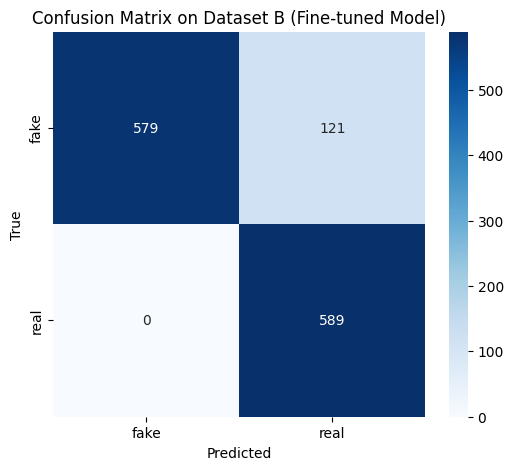


Saving the fine-tuned model to ./my_model_finetuned.keras...
Fine-tuned model saved successfully.


In [22]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam # Import Adam optimizer
import os
import shutil # Library for file operations (like copying)
import kagglehub
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns


# =====================================
# Configuration for Fine-Tuning
# =====================================
# Paths
PRETRAINED_MODEL_PATH = './my_model_trained_on_A.keras'
FINETUNED_MODEL_PATH = './my_model_finetuned.keras' # Path to save the fine-tuned model

# Original Dataset A paths (Assuming these variables are still defined from your previous cells)
# If not, redefine them here:
TRAIN_DIR_A = 'C:/Users/lzx13/.cache/kagglehub/datasets/xhlulu/140k-real-and-fake-faces/versions/2/real_vs_fake/real-vs-fake/train'
VAL_DIR_A = 'C:/Users/lzx13/.cache/kagglehub/datasets/xhlulu/140k-real-and-fake-faces/versions/2/real_vs_fake/real-vs-fake/valid'
TEST_DIR_A = 'C:/Users/lzx13/.cache/kagglehub/datasets/xhlulu/140k-real-and-fake-faces/versions/2/real_vs_fake/real-vs-fake/test'

# New Dataset B path (Download if not already present, get the path)
print("Locating/Downloading Dataset B ('hardfakevsrealfaces')...")
try:
    DATASET_B_PATH = kagglehub.dataset_download("hamzaboulahia/hardfakevsrealfaces")
    print(f"Dataset B path: {DATASET_B_PATH}")
    # Check if the dataset path contains 'fake' and 'real' subdirectories needed for flow_from_directory
    if not (os.path.exists(os.path.join(DATASET_B_PATH, 'fake')) and os.path.exists(os.path.join(DATASET_B_PATH, 'real'))):
         # If not, assume the structure might be nested, e.g., inside another folder. Adjust DATASET_B_PATH if needed.
         # Example adjustment (uncomment and modify if necessary):
         # potential_nested_path = os.path.join(DATASET_B_PATH, 'hardfakevsrealfaces') # Or whatever the actual subfolder name is
         # if os.path.exists(potential_nested_path) and os.path.exists(os.path.join(potential_nested_path, 'fake')):
         #    DATASET_B_PATH = potential_nested_path
         #    print(f"Adjusted Dataset B path to: {DATASET_B_PATH}")
         # else:
             print(f"Warning: Could not find 'fake'/'real' subdirs directly in {DATASET_B_PATH}. ImageDataGenerator might fail.")
             # Consider adding manual inspection or error handling here if the structure is unknown.

except Exception as e:
    print(f"Error downloading/locating dataset B with kagglehub: {e}")
    exit()


# Path for combined training data
COMBINED_TRAIN_DIR = './combined_train_data'

# Fine-tuning Hyperparameters (These are crucial!)
LEARNING_RATE = 1e-5  # Start with a low learning rate for fine-tuning
EPOCHS = 10           # Maximum number of epochs for fine-tuning (EarlyStopping will likely stop it sooner)
BATCH_SIZE = 32       # Usually kept the same as initial training
IMG_SIZE = (224, 224) # Should match the input size of your loaded model

# =====================================
# 1. Prepare Combined Training Data
# =====================================
print(f"Preparing combined training data in {COMBINED_TRAIN_DIR}...")

# Remove the combined directory if it exists to start fresh
if os.path.exists(COMBINED_TRAIN_DIR):
    print(f"Removing existing combined directory: {COMBINED_TRAIN_DIR}")
    shutil.rmtree(COMBINED_TRAIN_DIR)

# Create the directory structure: combined_train_data/fake and combined_train_data/real
os.makedirs(os.path.join(COMBINED_TRAIN_DIR, 'fake'), exist_ok=True)
os.makedirs(os.path.join(COMBINED_TRAIN_DIR, 'real'), exist_ok=True)

# Function to copy images
def copy_images(src_dir, dest_dir, class_name):
    """Copies images from src_dir/class_name to dest_dir/class_name."""
    src_class_dir = os.path.join(src_dir, class_name)
    dest_class_dir = os.path.join(dest_dir, class_name)
    if not os.path.exists(src_class_dir):
        print(f"Warning: Source directory not found {src_class_dir}")
        return 0
    count = 0
    for filename in os.listdir(src_class_dir):
        src_file = os.path.join(src_class_dir, filename)
        dest_file = os.path.join(dest_class_dir, filename)
        if os.path.isfile(src_file):
            try:
                # Add a prefix to avoid name collisions between datasets (optional but safer)
                new_filename = f"{class_name}_dataset_{os.path.basename(src_dir)}_{filename}"
                dest_file_prefixed = os.path.join(dest_class_dir, new_filename)
                shutil.copy2(src_file, dest_file_prefixed) # copy2 preserves metadata
                count += 1
            except Exception as e:
                print(f"Error copying {src_file} to {dest_file_prefixed}: {e}")
    print(f"Copied {count} images from {src_class_dir} to {dest_class_dir}")
    return count

# Copy training images from Dataset A
print("Copying Dataset A training images...")
copy_images(TRAIN_DIR_A, COMBINED_TRAIN_DIR, 'fake')
copy_images(TRAIN_DIR_A, COMBINED_TRAIN_DIR, 'real')

# Copy images from Dataset B (assuming it has 'fake' and 'real' subdirs)
print("Copying Dataset B images...")
copy_images(DATASET_B_PATH, COMBINED_TRAIN_DIR, 'fake')
copy_images(DATASET_B_PATH, COMBINED_TRAIN_DIR, 'real')

print("Finished preparing combined training data.")

# =====================================
# 2. Create Data Generators
# =====================================
# Generator for combined training data (with augmentation if desired)
train_datagen_combined = ImageDataGenerator(
    rescale=1./255,
    # Add augmentations if you used them in the original training, e.g.:
    # rotation_range=20,
    # width_shift_range=0.2,
    # height_shift_range=0.2,
    # shear_range=0.2,
    # zoom_range=0.2,
    # horizontal_flip=True,
    # fill_mode='nearest'
)

# Generator for Dataset A validation data (only rescaling)
valid_test_datagen_A = ImageDataGenerator(rescale=1./255)

# Generator for Dataset B data (only rescaling) - for evaluation
datagen_B = ImageDataGenerator(rescale=1./255)


# Create the generator flows
print("Creating data generators...")
train_generator_combined = train_datagen_combined.flow_from_directory(
    COMBINED_TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=True
)

# Use the original validation generator for Dataset A
valid_generator_A = valid_test_datagen_A.flow_from_directory(
    VAL_DIR_A,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

# Use the original test generator for Dataset A
test_generator_A = valid_test_datagen_A.flow_from_directory(
    TEST_DIR_A,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

# Create a generator for evaluating on all of Dataset B
# We reuse the DATASET_B_PATH, assuming it directly contains 'fake'/'real' folders
generator_B = datagen_B.flow_from_directory(
    DATASET_B_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

# Verify class indices are consistent (should be {'fake': 0, 'real': 1})
print("Class indices (Combined Train):", train_generator_combined.class_indices)
print("Class indices (Dataset A Val):", valid_generator_A.class_indices)
print("Class indices (Dataset B Eval):", generator_B.class_indices)
# If indices are different or swapped, this indicates a problem in data setup!

# =====================================
# 3. Load Pre-trained Model and Re-compile
# =====================================
print(f"Loading pre-trained model from {PRETRAINED_MODEL_PATH}...")
try:
    model = tf.keras.models.load_model(PRETRAINED_MODEL_PATH)
    print("Model loaded successfully.")
    # Optional: Print model summary to verify
    # model.summary()
except Exception as e:
    print(f"Error loading model: {e}")
    exit()

# Re-compile the model with a low learning rate for fine-tuning
# It's important to use a *new* optimizer instance
model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE), # Use Adam optimizer with the specified low learning rate
    loss='binary_crossentropy',
    metrics=['accuracy']
)
print(f"Model re-compiled with learning rate: {LEARNING_RATE}")

# =====================================
# 4. Fine-tune the Model
# =====================================
# Setup EarlyStopping for fine-tuning
early_stop_finetune = EarlyStopping(
    monitor='val_loss',       # Monitor validation loss on Dataset A's validation set
    patience=3,               # Stop if no improvement after 3 epochs (can adjust)
    restore_best_weights=True # Restore weights from the epoch with the best validation loss
)

print("Starting fine-tuning...")
history_finetune = model.fit(
    train_generator_combined,
    steps_per_epoch=max(1, train_generator_combined.samples // BATCH_SIZE), # Ensure at least 1 step
    epochs=EPOCHS,
    validation_data=valid_generator_A,
    validation_steps=max(1, valid_generator_A.samples // BATCH_SIZE), # Ensure at least 1 step
    callbacks=[early_stop_finetune]
)
print("Fine-tuning finished.")

# =====================================
# 5. Evaluate the Fine-tuned Model
# =====================================
print("\nEvaluating fine-tuned model on Dataset A (Test Set)...")
eval_A = model.evaluate(test_generator_A)
print(f"Dataset A - Test Loss: {eval_A[0]:.4f}, Test Accuracy: {eval_A[1]:.4f}")

print("\nEvaluating fine-tuned model on Dataset B...")
eval_B = model.evaluate(generator_B)
print(f"Dataset B - Loss: {eval_B[0]:.4f}, Accuracy: {eval_B[1]:.4f}")

# Detailed report for Dataset B
print("\nGenerating detailed report for Dataset B...")
try:
    predictions_B = model.predict(generator_B)
    predicted_classes_B = (predictions_B > 0.5).astype(int).flatten()
    true_classes_B = generator_B.classes
    target_names_B = [k for k, v in sorted(generator_B.class_indices.items(), key=lambda item: item[1])]

    print("\nDataset B - Accuracy Score:", accuracy_score(true_classes_B, predicted_classes_B))
    print("\nDataset B - Classification Report:")
    print(classification_report(true_classes_B, predicted_classes_B, target_names=target_names_B))

    print("\nDataset B - Confusion Matrix:")
    cm_B = confusion_matrix(true_classes_B, predicted_classes_B)
    print(cm_B)

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm_B, annot=True, fmt='d', cmap='Blues', xticklabels=target_names_B, yticklabels=target_names_B)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix on Dataset B (Fine-tuned Model)')
    plt.show()

except Exception as e:
    print(f"Error during detailed evaluation on Dataset B: {e}")


# =====================================
# 6. Save the Fine-tuned Model
# =====================================
print(f"\nSaving the fine-tuned model to {FINETUNED_MODEL_PATH}...")
try:
    model.save(FINETUNED_MODEL_PATH)
    print("Fine-tuned model saved successfully.")
except Exception as e:
    print(f"Error saving fine-tuned model: {e}")

Locating/Downloading Dataset B ('hardfakevsrealfaces')...
Dataset B path: C:\Users\lzx13\.cache\kagglehub\datasets\hamzaboulahia\hardfakevsrealfaces\versions\1
Preparing combined training data in ./combined_train_data...
Copying Dataset A training images...
Copied 50000 images from C:/Users/lzx13/.cache/kagglehub/datasets/xhlulu/140k-real-and-fake-faces/versions/2/real_vs_fake/real-vs-fake/train\fake to ./combined_train_data\fake
Copied 50000 images from C:/Users/lzx13/.cache/kagglehub/datasets/xhlulu/140k-real-and-fake-faces/versions/2/real_vs_fake/real-vs-fake/train\real to ./combined_train_data\real
Copying Dataset B images...
Copied 700 images from C:\Users\lzx13\.cache\kagglehub\datasets\hamzaboulahia\hardfakevsrealfaces\versions\1\fake to ./combined_train_data\fake
Copied 589 images from C:\Users\lzx13\.cache\kagglehub\datasets\hamzaboulahia\hardfakevsrealfaces\versions\1\real to ./combined_train_data\real
Finished preparing combined training data.
Creating data generators...
Fou

c:\Users\lzx13\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
3165/3165 ━━━━━━━━━━━━━━━━━━━━ 1293s 408ms/step - accuracy: 0.7898 - loss: 0.6181 - val_accuracy: 0.9022 - val_loss: 0.2345
Epoch 2/10
   1/3165 ━━━━━━━━━━━━━━━━━━━━ 11:08 211ms/step - accuracy: 0.9062 - loss: 0.2895

c:\Users\lzx13\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


3165/3165 ━━━━━━━━━━━━━━━━━━━━ 23s 7ms/step - accuracy: 0.9062 - loss: 0.2895 - val_accuracy: 0.9018 - val_loss: 0.2354
Epoch 3/10
3165/3165 ━━━━━━━━━━━━━━━━━━━━ 872s 275ms/step - accuracy: 0.8597 - loss: 0.3237 - val_accuracy: 0.9219 - val_loss: 0.1924
Epoch 4/10
3165/3165 ━━━━━━━━━━━━━━━━━━━━ 23s 7ms/step - accuracy: 0.9375 - loss: 0.2163 - val_accuracy: 0.9219 - val_loss: 0.1924
Epoch 5/10
3165/3165 ━━━━━━━━━━━━━━━━━━━━ 873s 276ms/step - accuracy: 0.8824 - loss: 0.2771 - val_accuracy: 0.9367 - val_loss: 0.1623
Epoch 6/10
3165/3165 ━━━━━━━━━━━━━━━━━━━━ 23s 7ms/step - accuracy: 0.9375 - loss: 0.2118 - val_accuracy: 0.9380 - val_loss: 0.1600
Epoch 7/10
3165/3165 ━━━━━━━━━━━━━━━━━━━━ 876s 277ms/step - accuracy: 0.8965 - loss: 0.2489 - val_accuracy: 0.9333 - val_loss: 0.1696
Epoch 8/10
3165/3165 ━━━━━━━━━━━━━━━━━━━━ 23s 7ms/step - accuracy: 0.9062 - loss: 0.2092 - val_accuracy: 0.9319 - val_loss: 0.1721
Epoch 9/10
3165/3165 ━━━━━━━━━━━━━━━━━━━━ 872s 275ms/step - accuracy: 0.9073 - loss: 

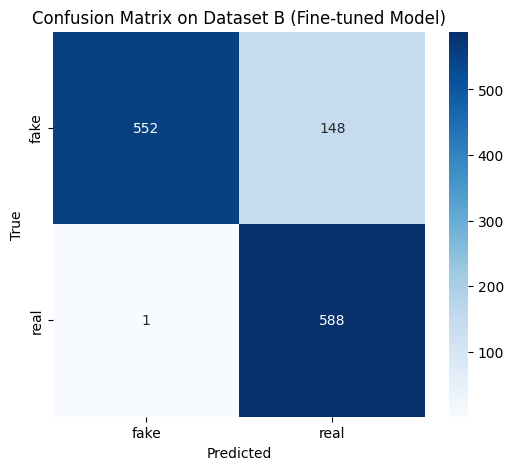


Saving the fine-tuned model to ./my_model_finetuned_v3.keras...
Fine-tuned model saved successfully.


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam # Import Adam optimizer
import os
import shutil # Library for file operations (like copying)
import kagglehub
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns


# =====================================
# Configuration for Fine-Tuning
# =====================================
# Paths

# Define the base model and path to new model, this one has hyperparameters on
PRETRAINED_MODEL_PATH = './my_model_trained_on_A.keras'
FINETUNED_MODEL_PATH = './my_model_finetuned_v3.keras' 

# Original Dataset A paths (Assuming these variables are still defined from your previous cells)
# If not, redefine them here:
TRAIN_DIR_A = 'C:/Users/lzx13/.cache/kagglehub/datasets/xhlulu/140k-real-and-fake-faces/versions/2/real_vs_fake/real-vs-fake/train'
VAL_DIR_A = 'C:/Users/lzx13/.cache/kagglehub/datasets/xhlulu/140k-real-and-fake-faces/versions/2/real_vs_fake/real-vs-fake/valid'
TEST_DIR_A = 'C:/Users/lzx13/.cache/kagglehub/datasets/xhlulu/140k-real-and-fake-faces/versions/2/real_vs_fake/real-vs-fake/test'

# New Dataset B path (Download if not already present, get the path)
print("Locating/Downloading Dataset B ('hardfakevsrealfaces')...")
try:
    DATASET_B_PATH = kagglehub.dataset_download("hamzaboulahia/hardfakevsrealfaces")
    print(f"Dataset B path: {DATASET_B_PATH}")
    # Check if the dataset path contains 'fake' and 'real' subdirectories needed for flow_from_directory
    if not (os.path.exists(os.path.join(DATASET_B_PATH, 'fake')) and os.path.exists(os.path.join(DATASET_B_PATH, 'real'))):
         # If not, assume the structure might be nested, e.g., inside another folder. Adjust DATASET_B_PATH if needed.
         # Example adjustment (uncomment and modify if necessary):
         # potential_nested_path = os.path.join(DATASET_B_PATH, 'hardfakevsrealfaces') # Or whatever the actual subfolder name is
         # if os.path.exists(potential_nested_path) and os.path.exists(os.path.join(potential_nested_path, 'fake')):
         #    DATASET_B_PATH = potential_nested_path
         #    print(f"Adjusted Dataset B path to: {DATASET_B_PATH}")
         # else:
             print(f"Warning: Could not find 'fake'/'real' subdirs directly in {DATASET_B_PATH}. ImageDataGenerator might fail.")
             # Consider adding manual inspection or error handling here if the structure is unknown.

except Exception as e:
    print(f"Error downloading/locating dataset B with kagglehub: {e}")
    exit()


# Path for combined training data
COMBINED_TRAIN_DIR = './combined_train_data'

# Fine-tuning Hyperparameters (These are crucial!)
LEARNING_RATE = 1e-5  # Start with a low learning rate for fine-tuning
EPOCHS = 10           # Maximum number of epochs for fine-tuning (EarlyStopping will likely stop it sooner)
BATCH_SIZE = 32       # Usually kept the same as initial training
IMG_SIZE = (224, 224) # Should match the input size of your loaded model

# =====================================
# 1. Prepare Combined Training Data
# =====================================
print(f"Preparing combined training data in {COMBINED_TRAIN_DIR}...")

# Remove the combined directory if it exists to start fresh
if os.path.exists(COMBINED_TRAIN_DIR):
    print(f"Removing existing combined directory: {COMBINED_TRAIN_DIR}")
    shutil.rmtree(COMBINED_TRAIN_DIR)

# Create the directory structure: combined_train_data/fake and combined_train_data/real
os.makedirs(os.path.join(COMBINED_TRAIN_DIR, 'fake'), exist_ok=True)
os.makedirs(os.path.join(COMBINED_TRAIN_DIR, 'real'), exist_ok=True)

# Function to copy images
def copy_images(src_dir, dest_dir, class_name):
    """Copies images from src_dir/class_name to dest_dir/class_name."""
    src_class_dir = os.path.join(src_dir, class_name)
    dest_class_dir = os.path.join(dest_dir, class_name)
    if not os.path.exists(src_class_dir):
        print(f"Warning: Source directory not found {src_class_dir}")
        return 0
    count = 0
    for filename in os.listdir(src_class_dir):
        src_file = os.path.join(src_class_dir, filename)
        dest_file = os.path.join(dest_class_dir, filename)
        if os.path.isfile(src_file):
            try:
                # Add a prefix to avoid name collisions between datasets (optional but safer)
                new_filename = f"{class_name}_dataset_{os.path.basename(src_dir)}_{filename}"
                dest_file_prefixed = os.path.join(dest_class_dir, new_filename)
                shutil.copy2(src_file, dest_file_prefixed) # copy2 preserves metadata
                count += 1
            except Exception as e:
                print(f"Error copying {src_file} to {dest_file_prefixed}: {e}")
    print(f"Copied {count} images from {src_class_dir} to {dest_class_dir}")
    return count

# Copy training images from Dataset A
print("Copying Dataset A training images...")
copy_images(TRAIN_DIR_A, COMBINED_TRAIN_DIR, 'fake')
copy_images(TRAIN_DIR_A, COMBINED_TRAIN_DIR, 'real')

# Copy images from Dataset B (assuming it has 'fake' and 'real' subdirs)
print("Copying Dataset B images...")
copy_images(DATASET_B_PATH, COMBINED_TRAIN_DIR, 'fake')
copy_images(DATASET_B_PATH, COMBINED_TRAIN_DIR, 'real')

print("Finished preparing combined training data.")

# =====================================
# 2. Create Data Generators
# =====================================
# Generator for combined training data (with augmentation if desired)
train_datagen_combined = ImageDataGenerator(
    rescale=1./255,
    # Add augmentations if you used them in the original training, e.g.:
    rotation_range=5,
    width_shift_range=0.02,
    height_shift_range=0.02,
    # shear_range=0.2,
    # zoom_range=0.2,
    horizontal_flip=True,
    # fill_mode='nearest'
)

# Generator for Dataset A validation data (only rescaling)
valid_test_datagen_A = ImageDataGenerator(rescale=1./255)

# Generator for Dataset B data (only rescaling) - for evaluation
datagen_B = ImageDataGenerator(rescale=1./255)


# Create the generator flows
print("Creating data generators...")
train_generator_combined = train_datagen_combined.flow_from_directory(
    COMBINED_TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=True
)

# Use the original validation generator for Dataset A
valid_generator_A = valid_test_datagen_A.flow_from_directory(
    VAL_DIR_A,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

# Use the original test generator for Dataset A
test_generator_A = valid_test_datagen_A.flow_from_directory(
    TEST_DIR_A,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

# Create a generator for evaluating on all of Dataset B
# We reuse the DATASET_B_PATH, assuming it directly contains 'fake'/'real' folders
generator_B = datagen_B.flow_from_directory(
    DATASET_B_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

# Verify class indices are consistent (should be {'fake': 0, 'real': 1})
print("Class indices (Combined Train):", train_generator_combined.class_indices)
print("Class indices (Dataset A Val):", valid_generator_A.class_indices)
print("Class indices (Dataset B Eval):", generator_B.class_indices)
# If indices are different or swapped, this indicates a problem in data setup!

# =====================================
# 3. Load Pre-trained Model and Re-compile
# =====================================
print(f"Loading pre-trained model from {PRETRAINED_MODEL_PATH}...")
try:
    model = tf.keras.models.load_model(PRETRAINED_MODEL_PATH)
    print("Model loaded successfully.")
    # Optional: Print model summary to verify
    # model.summary()
except Exception as e:
    print(f"Error loading model: {e}")
    exit()

# Re-compile the model with a low learning rate for fine-tuning
# It's important to use a *new* optimizer instance
model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE), # Use Adam optimizer with the specified low learning rate
    loss='binary_crossentropy',
    metrics=['accuracy']
)
print(f"Model re-compiled with learning rate: {LEARNING_RATE}")

# =====================================
# 4. Fine-tune the Model
# =====================================
# Setup EarlyStopping for fine-tuning
early_stop_finetune = EarlyStopping(
    monitor='val_loss',       # Monitor validation loss on Dataset A's validation set
    patience=3,               # Stop if no improvement after 3 epochs (can adjust)
    restore_best_weights=True # Restore weights from the epoch with the best validation loss
)

print("Starting fine-tuning...")
history_finetune = model.fit(
    train_generator_combined,
    steps_per_epoch=max(1, train_generator_combined.samples // BATCH_SIZE), # Ensure at least 1 step
    epochs=EPOCHS,
    validation_data=valid_generator_A,
    validation_steps=max(1, valid_generator_A.samples // BATCH_SIZE), # Ensure at least 1 step
    callbacks=[early_stop_finetune]
)
print("Fine-tuning finished.")

# =====================================
# 5. Evaluate the Fine-tuned Model
# =====================================
print("\nEvaluating fine-tuned model on Dataset A (Test Set)...")
eval_A = model.evaluate(test_generator_A)
print(f"Dataset A - Test Loss: {eval_A[0]:.4f}, Test Accuracy: {eval_A[1]:.4f}")

print("\nEvaluating fine-tuned model on Dataset B...")
eval_B = model.evaluate(generator_B)
print(f"Dataset B - Loss: {eval_B[0]:.4f}, Accuracy: {eval_B[1]:.4f}")

# Detailed report for Dataset B
print("\nGenerating detailed report for Dataset B...")
try:
    predictions_B = model.predict(generator_B)
    predicted_classes_B = (predictions_B > 0.5).astype(int).flatten()
    true_classes_B = generator_B.classes
    target_names_B = [k for k, v in sorted(generator_B.class_indices.items(), key=lambda item: item[1])]

    print("\nDataset B - Accuracy Score:", accuracy_score(true_classes_B, predicted_classes_B))
    print("\nDataset B - Classification Report:")
    print(classification_report(true_classes_B, predicted_classes_B, target_names=target_names_B))

    print("\nDataset B - Confusion Matrix:")
    cm_B = confusion_matrix(true_classes_B, predicted_classes_B)
    print(cm_B)

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm_B, annot=True, fmt='d', cmap='Blues', xticklabels=target_names_B, yticklabels=target_names_B)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix on Dataset B (Fine-tuned Model)')
    plt.show()

except Exception as e:
    print(f"Error during detailed evaluation on Dataset B: {e}")


# =====================================
# 6. Save the Fine-tuned Model
# =====================================
print(f"\nSaving the fine-tuned model to {FINETUNED_MODEL_PATH}...")
try:
    model.save(FINETUNED_MODEL_PATH)
    print("Fine-tuned model saved successfully.")
except Exception as e:
    print(f"Error saving fine-tuned model: {e}")

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam # Or any optimizer, just for compilation
import os
import shutil
import kagglehub
import numpy as np

# =====================================
# Configuration
# =====================================
# --- Define paths to your models ---
MODEL_PATHS = {
    "Initial Model (A)": "./my_model_trained_on_A.keras",
    "FineTuned Model V1": "./my_model_finetuned.keras",
    "FineTuned Model V2": "./my_model_finetuned_v2.keras",
    "FineTuned Model V3": "./my_model_finetuned_v3.keras", # Add this if you ran V3
}

# --- Dataset Paths (Ensure these are correct) ---
# Dataset A
VAL_DIR_A = 'C:/Users/lzx13/.cache/kagglehub/datasets/xhlulu/140k-real-and-fake-faces/versions/2/real_vs_fake/real-vs-fake/valid'
TEST_DIR_A = 'C:/Users/lzx13/.cache/kagglehub/datasets/xhlulu/140k-real-and-fake-faces/versions/2/real_vs_fake/real-vs-fake/test'

# Dataset B
print("Locating/Downloading Dataset B ('hardfakevsrealfaces')...")
try:
    DATASET_B_PATH = kagglehub.dataset_download("hamzaboulahia/hardfakevsrealfaces")
    print(f"Dataset B path: {DATASET_B_PATH}")
except Exception as e:
    print(f"Error downloading/locating dataset B with kagglehub: {e}")
    exit()

# Path for the new combined test data
COMBINED_TEST_DIR = './combined_test_data_for_evaluation'

# --- General Parameters ---
IMG_SIZE = (224, 224)
BATCH_SIZE = 32 # For evaluation, batch size doesn't impact results, only speed/memory

# =====================================
# Helper function to copy images
# =====================================
def copy_images_for_evaluation(src_dir_base, dest_dir_base, class_name, dataset_prefix):
    """Copies images from src_dir_base/class_name to dest_dir_base/class_name with a prefix."""
    src_class_dir = os.path.join(src_dir_base, class_name)
    dest_class_dir = os.path.join(dest_dir_base, class_name)
    
    if not os.path.exists(src_class_dir):
        print(f"Warning: Source directory not found for copying: {src_class_dir}")
        return 0
    
    os.makedirs(dest_class_dir, exist_ok=True) # Ensure destination class directory exists
    
    count = 0
    for filename in os.listdir(src_class_dir):
        src_file = os.path.join(src_class_dir, filename)
        if os.path.isfile(src_file):
            try:
                # Add a prefix to avoid name collisions between datasets
                new_filename = f"{dataset_prefix}_{class_name}_{filename}"
                dest_file_prefixed = os.path.join(dest_class_dir, new_filename)
                shutil.copy2(src_file, dest_file_prefixed)
                count += 1
            except Exception as e:
                print(f"Error copying {src_file} to {dest_file_prefixed}: {e}")
    print(f"Copied {count} images from {src_class_dir} (as {dataset_prefix}) to {dest_class_dir}")
    return count

# =====================================
# 1. Prepare Combined Test Data
# =====================================
print(f"\nPreparing combined test data in {COMBINED_TEST_DIR}...")
if os.path.exists(COMBINED_TEST_DIR):
    print(f"Removing existing combined test directory: {COMBINED_TEST_DIR}")
    shutil.rmtree(COMBINED_TEST_DIR)

os.makedirs(os.path.join(COMBINED_TEST_DIR, 'fake'), exist_ok=True)
os.makedirs(os.path.join(COMBINED_TEST_DIR, 'real'), exist_ok=True)

# Copy test images from Dataset A
print("Copying Dataset A test images for combined set...")
copy_images_for_evaluation(TEST_DIR_A, COMBINED_TEST_DIR, 'fake', 'DatasetA')
copy_images_for_evaluation(TEST_DIR_A, COMBINED_TEST_DIR, 'real', 'DatasetA')

# Copy all images from Dataset B (as its "test" set)
print("Copying Dataset B images for combined set...")
# Ensure DATASET_B_PATH directly contains 'fake' and 'real' subdirs
copy_images_for_evaluation(DATASET_B_PATH, COMBINED_TEST_DIR, 'fake', 'DatasetB')
copy_images_for_evaluation(DATASET_B_PATH, COMBINED_TEST_DIR, 'real', 'DatasetB')

print("Finished preparing combined test data.")

# =====================================
# 2. Create Data Generators for Evaluation
# =====================================
print("\nCreating data generators for evaluation...")
eval_datagen = ImageDataGenerator(rescale=1./255) # Only rescaling for evaluation

# Generator for Dataset A Validation Set
valid_generator_A = eval_datagen.flow_from_directory(
    VAL_DIR_A,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False # IMPORTANT for evaluation
)

# Generator for Dataset A Test Set
test_generator_A = eval_datagen.flow_from_directory(
    TEST_DIR_A,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False # IMPORTANT
)

# Generator for Dataset B (all data)
generator_B = eval_datagen.flow_from_directory(
    DATASET_B_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False # IMPORTANT
)

# Generator for the Combined Test Set
combined_test_generator = eval_datagen.flow_from_directory(
    COMBINED_TEST_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False # IMPORTANT
)

print("\nClass Indices (should be consistent, e.g., {'fake': 0, 'real': 1}):")
print(f"  Dataset A Val: {valid_generator_A.class_indices}")
print(f"  Dataset A Test: {test_generator_A.class_indices}")
print(f"  Dataset B: {generator_B.class_indices}")
print(f"  Combined Test: {combined_test_generator.class_indices}")

# =====================================
# 3. Evaluate Models
# =====================================
results_summary = {}

for model_name, model_path in MODEL_PATHS.items():
    print(f"\n--- Evaluating Model: {model_name} ---")
    if not os.path.exists(model_path):
        print(f"Model file not found: {model_path}. Skipping.")
        continue

    try:
        model = tf.keras.models.load_model(model_path)
        # Compile is not strictly necessary for evaluate if model was saved compiled,
        # but doing so ensures metrics are consistently defined.
        model.compile(optimizer=Adam(learning_rate=1e-5), # LR doesn't matter for eval
                      loss='binary_crossentropy',
                      metrics=['accuracy'])
        print(f"Successfully loaded and compiled: {model_path}")

        model_results = {}

        # Evaluate on Dataset A Validation Set
        print(f"\n  Evaluating on Dataset A Validation Set...")
        valid_A_results = model.evaluate(valid_generator_A, verbose=0)
        model_results["Dataset A Validation"] = {"loss": valid_A_results[0], "accuracy": valid_A_results[1]}
        print(f"    Loss: {valid_A_results[0]:.4f}, Accuracy: {valid_A_results[1]:.4f}")
        valid_generator_A.reset() # Good practice

        # Evaluate on Dataset A Test Set
        print(f"\n  Evaluating on Dataset A Test Set...")
        test_A_results = model.evaluate(test_generator_A, verbose=0)
        model_results["Dataset A Test"] = {"loss": test_A_results[0], "accuracy": test_A_results[1]}
        print(f"    Loss: {test_A_results[0]:.4f}, Accuracy: {test_A_results[1]:.4f}")
        test_generator_A.reset()

        # Evaluate on Dataset B
        print(f"\n  Evaluating on Dataset B...")
        test_B_results = model.evaluate(generator_B, verbose=0)
        model_results["Dataset B"] = {"loss": test_B_results[0], "accuracy": test_B_results[1]}
        print(f"    Loss: {test_B_results[0]:.4f}, Accuracy: {test_B_results[1]:.4f}")
        generator_B.reset()
        
        # Evaluate on Combined Test Set
        print(f"\n  Evaluating on Combined Test Set...")
        combined_test_results = model.evaluate(combined_test_generator, verbose=0)
        model_results["Combined Test Set"] = {"loss": combined_test_results[0], "accuracy": combined_test_results[1]}
        print(f"    Loss: {combined_test_results[0]:.4f}, Accuracy: {combined_test_results[1]:.4f}")
        combined_test_generator.reset()

        results_summary[model_name] = model_results

    except Exception as e:
        print(f"Error evaluating model {model_name} from {model_path}: {e}")

# =====================================
# 4. Print Summary of Results
# =====================================
print("\n\n--- Overall Results Summary ---")
for model_name, evaluations in results_summary.items():
    print(f"\nModel: {model_name}")
    for eval_name, metrics in evaluations.items():
        print(f"  {eval_name}: Loss = {metrics['loss']:.4f}, Accuracy = {metrics['accuracy']:.4f}")

# =====================================
# 5. Optional: Cleanup Combined Test Directory
# =====================================
# try:
#     print(f"\nRemoving temporary combined test directory: {COMBINED_TEST_DIR}")
#     shutil.rmtree(COMBINED_TEST_DIR)
#     print("Cleanup successful.")
# except Exception as e:
#     print(f"Error during cleanup: {e}")


Locating/Downloading Dataset B ('hardfakevsrealfaces')...
Dataset B path: C:\Users\lzx13\.cache\kagglehub\datasets\hamzaboulahia\hardfakevsrealfaces\versions\1

Preparing combined test data in ./combined_test_data_for_evaluation...
Copying Dataset A test images for combined set...
Copied 10000 images from C:/Users/lzx13/.cache/kagglehub/datasets/xhlulu/140k-real-and-fake-faces/versions/2/real_vs_fake/real-vs-fake/test\fake (as DatasetA) to ./combined_test_data_for_evaluation\fake
Copied 10000 images from C:/Users/lzx13/.cache/kagglehub/datasets/xhlulu/140k-real-and-fake-faces/versions/2/real_vs_fake/real-vs-fake/test\real (as DatasetA) to ./combined_test_data_for_evaluation\real
Copying Dataset B images for combined set...
Copied 700 images from C:\Users\lzx13\.cache\kagglehub\datasets\hamzaboulahia\hardfakevsrealfaces\versions\1\fake (as DatasetB) to ./combined_test_data_for_evaluation\fake
Copied 589 images from C:\Users\lzx13\.cache\kagglehub\datasets\hamzaboulahia\hardfakevsrealfac

c:\Users\lzx13\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


    Loss: 0.0601, Accuracy: 0.9798

  Evaluating on Dataset A Test Set...
    Loss: 0.0626, Accuracy: 0.9782

  Evaluating on Dataset B...
    Loss: 1.6982, Accuracy: 0.6330

  Evaluating on Combined Test Set...
    Loss: 0.1616, Accuracy: 0.9573

--- Evaluating Model: FineTuned Model V1 ---
Successfully loaded and compiled: ./my_model_finetuned.keras

  Evaluating on Dataset A Validation Set...
    Loss: 0.0574, Accuracy: 0.9805

  Evaluating on Dataset A Test Set...
    Loss: 0.0624, Accuracy: 0.9789

  Evaluating on Dataset B...
    Loss: 0.2711, Accuracy: 0.9061

  Evaluating on Combined Test Set...
    Loss: 0.0751, Accuracy: 0.9745

--- Evaluating Model: FineTuned Model V2 ---
Successfully loaded and compiled: ./my_model_finetuned_v2.keras

  Evaluating on Dataset A Validation Set...
    Loss: 0.1293, Accuracy: 0.9522

  Evaluating on Dataset A Test Set...
    Loss: 0.1275, Accuracy: 0.9527

  Evaluating on Dataset B...
    Loss: 0.1978, Accuracy: 0.9178

  Evaluating on Combined